In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as SKMeans
from scipy.spatial import distance

# K Means

## 1. Top-Level

### 1.1 High-level explanation

K means is an unsupervised clustering algorithm which will attempt to find the center of "like features" based on the summed euclidean distance of all data given. This algorithm is greedy in the sense that its decision to group things is absolute. Consider the example below of two Gaussian clouds. We assume that a K means algorithm found the center of the clusters to be $(-2,-2)={\rm Blue}$, and $(2,2)={\rm Red}$. We then get a new data point at location $(0,0.1)$, shown in black, and we ask "What cluster does this point belong to?"

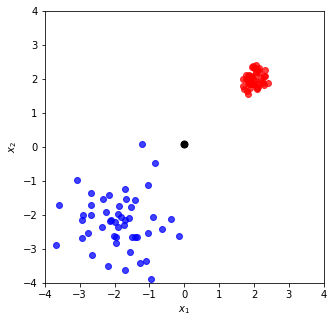

In [63]:
X = np.zeros(shape=(100,2))
Y = np.zeros(shape=(100))
X[:50,:] = np.random.randn(50,2)/5 + 2
X[50:,:] = np.random.randn(50,2)/1.2- 2
Y[:50] = 1
plt.figure(figsize=(5,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='b', alpha=.75)
plt.scatter(X[Y==1,0], X[Y==1,1], color='r', alpha=.75)
plt.scatter([0], [0.1], color='black', s=50)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

To find which cluster this new data point would belong to, we find the euclidean distance to the centers.

$$
\begin{align*}
\Delta_b &=  \sqrt { \sum_i \left( c^b_i - x_i \right)^2 } \\
&= 2.9 \\ \\[5mm]
\Delta_r &=  \sqrt { \sum_i \left( c^r_i - x_i \right)^2 } \\ 
&= 2.76
\end{align*}
$$

Because $\Delta_r < \Delta_b$ we say (with 100% confidence) that the new data point belongs to the ${\rm Red}$ cluster.

### 1.2 What scenario should you use K means?

K-means is a general-purpose clustering approach (the fastest). It can be used when even sized, spherical clusters can be assumed. It preforms best when there are only a few clusters.

In industry, k-means is used in: User segmentation (based on behaviors, like purchase history, interests). Grouping inventory based on sales activity. Detecting bots from humans. Seeing if a tracked point is changing groups over time. Detect activity types in motion sensors

### 1.3 How does this deal with outliers? Skewed data?

It is sensitive to outliers. (k-medians will be less sensitive.)

With squared error metric, outliers will influence cluster formation.  Resulting clusters may not be truly representative of what they should be, SSE metric is higher as well.  Depending on application, it can be useful to discover and remove outliers beforehand.  Alternatively, outliers can be removed during preprocessing.  Keep track of SSE contributed by each point, and eliminate those points with unusually high contributions, especially over multiple runs.  

During post-processing, can also eliminate small clusters since they can frequently represent groups of outliers.

### 1.4 What types of features does the model use?

The model makes the assumption that the data is clustered into spherical groups: Text, and continuous data. It doesn't work with categorical... but there are some ways to do it)

- Assumes Numeric data. Doesn't work with Categorical (Cardinal or Ordinal) data. 
To avoid this, feature engineering can be done: 
1. Ordinal data can be replaced with arithmetic sequence of appropriate difference. Say, small/large can be replaced by 5/10. Because of unit normalization, difference doesn’t really matter.
2. For cardinal data the values can be converted to binary values. However, this increases the dimensions (leading to the curse of dimensionality). So another approach is to use a different distance for categorical data; like Gower distance in R, Hamming distance in k-modes. (Gower distance is a dissimilarity measure.)


### 1.4 When does  the model break?
The model will break when the data does not fall into spherical groups. For example, consider two elliptical cluster:

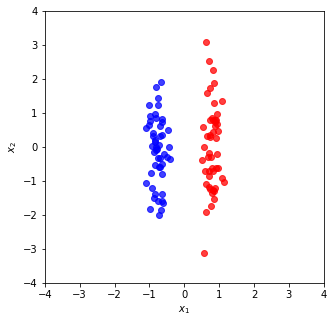

In [69]:
X = np.zeros(shape=(100,2))
Y = np.zeros(shape=(100))
X[:50,:] = np.transpose([np.random.randn(50,1)/6 + .75, np.random.randn(50,1)])
X[50:,:] = np.transpose([np.random.randn(50,1)/6 - .75, np.random.randn(50,1)])
Y[:50] = 1
plt.figure(figsize=(5,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='b', alpha=.75)
plt.scatter(X[Y==1,0], X[Y==1,1], color='r', alpha=.75)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

We run SK-learn's Kmeans algorithm on the input data, to find the predicted categories:

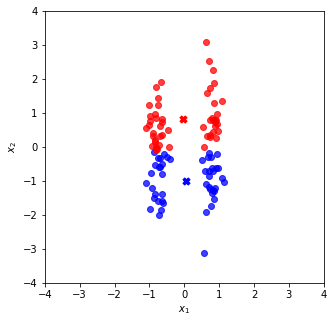

In [72]:
kmeans = SKMeans(2, algorithm='elkan')
Y_hat = kmeans.fit_predict(X)

plt.figure(figsize=(5,5))
plt.scatter(X[Y_hat==0,0], X[Y_hat==0,1], color='b', alpha=.75)
plt.scatter(X[Y_hat==1,0], X[Y_hat==1,1], color='r', alpha=.75)
Cb, Cr = kmeans.cluster_centers_
plt.scatter(Cb[0], Cb[1], color='b', marker='X', s=50)
plt.scatter(Cr[0], Cr[1], color='r', marker='X', s=50)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

The "X-marker" marks the predicted centers of the ${\rm Red}$ and ${\rm Blue}$ clusters. We can see it's converged to an incorrect location, despite there being an obvious separation of the data.  

### 1.5 What to use when it breaks? Whats a good back up?

It depends on how the method breaks:

Sklearn has a good table on the use cases and fall-back models for clustering:

http://scikit-learn.org/stable/modules/clustering.html

DB scan seems pretty cool...

One fix that is worth talking about in more detail is to use "soft kmeans," also called "Fuzzy Clustering". Soft kmeans will take into account the distance of a point from the centroid, thereby assigning a "confidence" to the value belonging to that cluster. This can be important for handling outliers, as in the first example. Soft kmeans is described more below.

## 2. A bit more detail

### 2.1 Normalize  of data

Because we're concerned with euclidean distance,

$$
\Delta = \sqrt{ (x-\mu_x)^2 + (y-\mu_y)^2 },
$$

if the coordinates have a different scaling, then k means will preferentially cluster the point on the axis with shorter distance. Therefore should scale the features to, make 0 mean and unit variance (from -1 to 1, along each dimension).

In the end this depends on the data: latitude and longitude should not scaled, because this will cause distortions.


### 2.2 How to initialize parameters?

The parameter to be initialized is the k (number of clusters).

Choosing the k centroids:
- The most basic method is to choose k random samples from the dataset. [According to Andrew Ng, run k means multiple times, and choose the one with the lowest cost.]
- However, to avoid local minimum, one method is to use the k-means++ initialization scheme. This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization. This is implemented in scikit-learn.

### 2.3 What's the loss function used?

Soft and hard Kmeans algorithms implement coordinate descent (not gradient descent), such that the center of the centroid is updated based on the mean (or weighted mean) of the data points assigned to that cluster. Because both of these functions are monotonically decreasing, kmeans is guaranteed to converge; however, it will probably converge to a local minima.

#### 2.3.1 Hard Kmeans

The loss function for hard kmeans is the 

$$
\mu_i \leftarrow \cfrac{\sum_i x_i}{\sum_i i}
$$


#### 2.3.1 Soft Kmeans

In soft k means, the loss function is weighted by a probability that the data point belongs to that cluster, denoted the 'responsibility', $r$.

$$
\mu_i \leftarrow \cfrac{\sum_n r_i^n x^n}{\sum_n r_i^n }
$$

with

$$
r_{i}^n = \cfrac{ \exp \left \{- \beta \delta(\mu_i, x^n) \right \}}{\sum_j \exp \left \{- \beta \delta(\mu_j, x^n) \right \} }
$$

$\delta$ being the euclidean distance between a point x_i and the closest centroid, $\mu$, and $\beta$ is a weighting constant (I think usually it's just set to 1) **Look this up**.

This method alleviates the ambiguity of a point belonging to a certain class, as in the first example of a point landing in the middle of two clusters.

#### 2.3.3 Visulization of Soft and Hard Kmeans

Consider the two gaussian clouds in 1D below

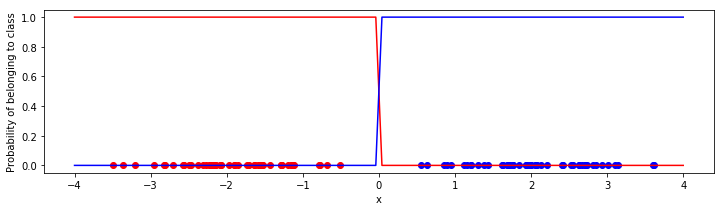

In [65]:
x = np.ones(100)
x[:50] = .75*np.random.randn(50)-2
x[50:] = .75*np.random.randn(50)+2

y = np.zeros_like(x)
c = np.zeros_like(x)
c[50:] = 1

i = np.linspace(-4,4,100)
r = np.zeros_like(x)
b = np.zeros_like(x)
r = np.abs(i-2) > np.abs(i+2)
b = np.abs(i-2) < np.abs(i+2)

plt.figure(figsize=(12,3))
plt.plot(x[c==0], y[c==0], 'ro')
plt.plot(x[c==1], y[c==1], 'bo')
plt.plot(i, r.astype(int), 'r')
plt.plot(i, b.astype(int), 'b')
plt.ylabel("Probability of belonging to class")
plt.xlabel("x")
plt.show()

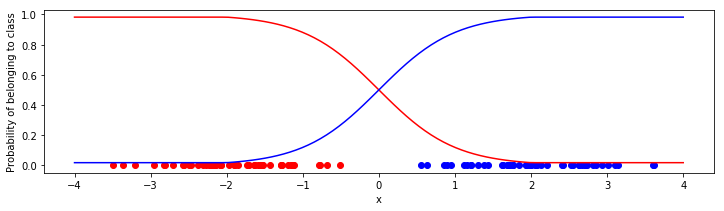

In [66]:
i = np.linspace(-4,4,100)
r = np.exp(-np.abs(-2-i)) / (np.exp(-np.abs(-2-i)) + np.exp(-np.abs(2-i)))
b = np.exp(-np.abs(2-i)) / (np.exp(-np.abs(-2-i)) + np.exp(-np.abs(2-i)))
plt.figure(figsize=(12,3))
plt.plot(x[c==0], y[c==0], 'ro')
plt.plot(x[c==1], y[c==1], 'bo')
plt.plot(i, r , 'r')
plt.plot(i, b , 'b')
plt.ylabel("Probability of belonging to class")
plt.xlabel("x")
plt.show()

### 2.4 What's the complexity? Does it scale?

The complexity of the problem is of the order 

$$
\mathcal{O}(I\cdot N\cdot D \cdot C)
$$

wherein $I$ is iterations; $N$ is number of data points; $D$ is dimensions; and $C$ is the number of clusters. Some short cuts can be taken, such as only taken a small sample of the total number of data points (mini-batch). K-means will still struggle with large datasets, but it does better than the other options.

## 3. In-depth

### 3.1 Derive the math

The math behind kmeans is quite simple, and there's nothing really to derive, so we'll just do a simple step-by-step example. Say we have data that we're trying to cluster, we drop two centroids onto the data at random locations:

To converge on the clusters we will do the following steps:

 1. Calculate the distance from every single data point to centroid 1 and centroid 2
 2. Assign each data point to the centroid that it is closer to
 3. For every single data point assigned to a cluster, take the mean value $\frac{1}{N}\sum_i (x_i, y_i)$
 4. Move the centroid to this coordinate
 5. Repeat

### 3.2 Simple implementation

In [131]:
class Kmeans:
    
    def __init__(self, clusters):
        self._num_clusters = 2
    
    @property
    def centroids(self):
        return self._centroids
    
    def fit(self, X, epochs=10):
        N, D = X.shape
        self._centroids = X.max(axis=0)*np.random.random((self._num_clusters, D))
        Y = np.zeros(N)
        _deltas = np.zeros((self._num_clusters, N))
        
        # Repeate for the number of specified iterations
        for _ in range(epochs):
            
            # Find the eculidian distance
            for c in range(self._num_clusters):
                _deltas[c,...] = np.sqrt(
                    np.sum(
                        np.subtract(self._centroids[c,...], X)**2, 
                        axis=1
                    )
                )
            
            # Assign the data with minimum distances to the respective centroids
            Y = np.argmin(_deltas, axis=0)
            
            # Update the centroid locations based on the mean of the assigned clusters
            for c in range(self._num_clusters):
                self._centroids[c,...] = X[Y==c].mean(axis=0)
    
        return Y

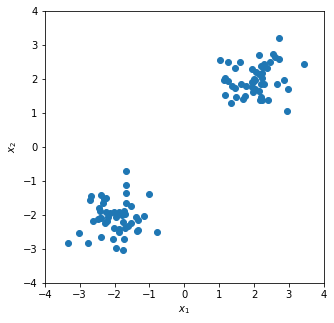

In [132]:
X = np.zeros(shape=(100,2))
X[:50,:] = np.random.randn(50,2)/2 + 2
X[50:,:] = np.random.randn(50,2)/2 - 2
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

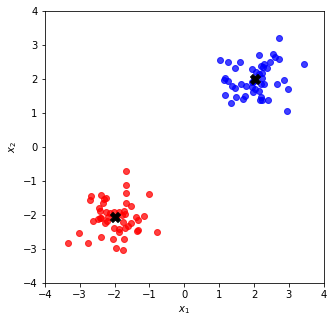

In [137]:
kmeans = Kmeans(clusters=2)
Y = kmeans.fit(X)
C = kmeans.centroids

plt.figure(figsize=(5,5))
plt.scatter(X[Y==0,0], X[Y==0,1], color='b', alpha=.75)
plt.scatter(X[Y==1,0], X[Y==1,1], color='r', alpha=.75)
plt.scatter(*C.T, color='black', marker='X', s=100)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()
plt.show()

## 4. More on training the model

### 4.1 How to deal with imbalanced data?

k-means does not care about cluster cardinalities

### 4.2 How well does it generalize to unseen data (over-fitting vs under-fitting)?

overfits if u set k=n, underfits if k = 1

### 4.3 What if you have MANY more features than sample points? Vice versa? (A variation of the above over/under fitting)

Curse of dimensionality. In high dimensions the (euclidean) distances are similar, making them pretty much useless.

### 4.4 How can you validate the model?

#### 4.4.1 Purity

External validation method:

$$
P = \frac{1}{N} \sum_k^K \max_{j=1...K} \left | c_k \cap  t_j \right |
$$

#### 4.4.2 Davis-Bouldin Index

Internal validation method:

$$
DBI = \frac{1}{K}\sum_i^K \max_{j \neq k} \left [ \frac{\sigma_j + \sigma_k}{\delta(c_j, c_k)} \right ]
$$

with $\sigma$ = average distance between each data point and the cluster center, i.e.

$$
\sigma_j = \frac{1}{N}\sum_i \delta(c_j, x_i)
$$

### 4.5  Does the model emphasize Type 1 or Type 2 errors?

For anomaly detection, its shown to have LOW type 1 errors (false positives). We can use precision and recall (though not widely reused), but of course we need to know the labels

Top-level
 - What is the high-level version, explain in layman's terms
 - What scenario should you use it in (classification vs regression, noisy data vs clean data)?
 - How does this deal with outliers? Skewed data?
 - What assumptions does the model make about the data? (Linear, etc)?
 - What types of features does the model use (continuous vs categorical)?
 - When does the model break/fail (adv & dis-advantages)?
 - use cases/alternatives when it breaks

A bit more detail:
 - How do you normalize the data for the model, if you need to?
 - How to initialize parameters at beginning (e.g. where to put centroid in KMeans)
 - What's the loss function used (if many, what are tradeoffs of each)?
 - What optimizers can you use here?
 - What's the complexity — runtime, parameters?
 - How does it scale with # of features or input data?
 
In-depth
 - probabilistic interpretation
 - Derive the math (only for a couple models)
 - Code up implementation (only for a couple models)

More on training the model (not model-specific, this should be common for most of the models):
 - How to deal with imbalanced data?
 - How well does it generalize to unseen data (over-fitting vs under-fitting)?
 - What if you have MANY more features than sample points? Vice versa? (A variation of the above over/under fitting)
 - How do you regularize the model? Tradeoffs?
 - How can you validate the model?
 - Does the model emphasize Type 1 or Type 2 errors?
 
 
<div id='ref'></div>
## 6. References